# 3. Classification Model - Predicting Stock Prices Using Granger Causality & Decision Tree

This notebook continues the analysis from Notebook 2, where we performed a Sentiment Analysis to tweets. Here, we refine the dataset, analyze key variables, perform a Granger Causality test, and build a Random Forest model to predict stock movement direction.

If you haven't completed Notebook 2, don’t worry! The required dataset has been included in the data repo folder so you can follow along.

## Importing Required Libraries & Loading the Dataset

Make sure to install the dependencies listed in **requirements.txt** before running the code.

In [1]:
# Nedeed libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Loading dataset into a Pandas DataFrame
stock_tweets = pd.read_csv('../Data/tesla_tweet_stock.csv')
stock_tweets.drop('Unnamed: 0', inplace=True, axis=1)
stock_tweets.head()

,date,open,close,polarity,subjectivity,neg,neu,pos,compound,change,direction
0,2022-04-11,326.800,325.310,0.080180,0.276989,0.026003,0.882427,0.091573,0.208212,-1.490,down
1,2022-04-12,332.547,328.983,0.105863,0.298063,0.030610,0.881667,0.087727,0.187490,-3.564,down
2,2022-04-13,327.025,340.790,0.097394,0.313199,0.033751,0.885848,0.080401,0.143989,13.765,up
3,2022-04-14,333.097,328.333,0.070293,0.290837,0.059377,0.864065,0.076561,0.094256,-4.764,down
4,2022-04-18,329.677,334.763,0.117096,0.280977,0.024602,0.870471,0.104924,0.223253,5.086,up


In [5]:
stock_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          148 non-null    object 
 1   open          148 non-null    float64
 2   close         148 non-null    float64
 3   polarity      148 non-null    float64
 4   subjectivity  148 non-null    float64
 5   neg           148 non-null    float64
 6   neu           148 non-null    float64
 7   pos           148 non-null    float64
 8   compound      148 non-null    float64
 9   change        148 non-null    float64
 10  direction     148 non-null    object 
dtypes: float64(9), object(2)
memory usage: 12.8+ KB


## Analyzing the Distribution of Compound Sentiment Scores

Before proceeding with modeling, we first visualize the distribution of the compound sentiment score. This helps us understand the spread and identify potential outliers that may affect our model's performance.

In [9]:
stock_tweets.describe()

,open,close,polarity,subjectivity,neg,neu,pos,compound,change
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,261.709880,260.667505,0.091377,0.283425,0.035208,0.885101,0.079673,0.136578,-1.042376
std,38.646659,38.066545,0.038853,0.044798,0.011493,0.018280,0.014781,0.068210,9.300594
min,186.000000,177.590000,-0.161589,0.202816,0.019388,0.793619,0.057006,-0.228570,-39.670000
25%,229.702500,230.929750,0.072939,0.262947,0.028767,0.877216,0.070178,0.106226,-6.557250
50%,254.803500,252.981500,0.090302,0.279789,0.032976,0.887131,0.077780,0.136064,-0.897500
75%,295.166750,292.132500,0.108593,0.296778,0.038852,0.896684,0.085644,0.166115,5.021500
max,358.243000,342.717000,0.240565,0.554429,0.116446,0.918091,0.160499,0.421482,16.600000


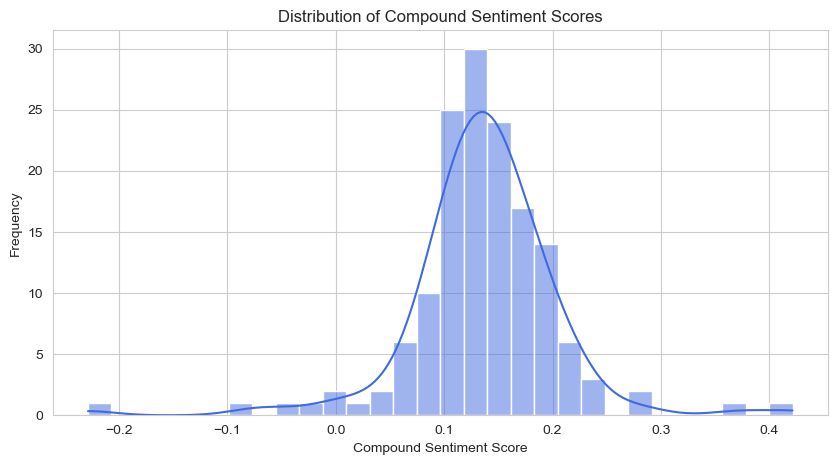

In [11]:
# Plot style
sns.set_style("whitegrid")

# Histogram with KDE
plt.figure(figsize=(10, 5))
sns.histplot(stock_tweets["compound"], bins=30, kde=True, color="royalblue")

# Labels and title
plt.xlabel("Compound Sentiment Score")
plt.ylabel("Frequency")
plt.title("Distribution of Compound Sentiment Scores")

# Show the plot
plt.show()

### Removing Outliers from the Compound Score

Outliers can distort predictions, especially in models sensitive to extreme values. We apply an **outlier removal method** to filter out extreme values in the compound column, ensuring a cleaner dataset for analysis.

In [15]:
# Q1 (25th percentile) and Q3 (75th percentile)
Q1 = stock_tweets["compound"].quantile(0.25)
Q3 = stock_tweets["compound"].quantile(0.75)
IQR = Q3 - Q1  # Interquartile range

# Lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Outliers
outliers = stock_tweets[(stock_tweets["compound"] < lower_bound) | (stock_tweets["compound"] > upper_bound)]
print(f"Number of outliers: {outliers.shape[0]}")
outliers.head()

Number of outliers: 10


,date,open,close,polarity,subjectivity,neg,neu,pos,compound,change,direction
25,2022-05-19,235.667,236.473,0.071521,0.292359,0.065626,0.865711,0.068654,-0.015325,0.806,up
30,2022-05-26,220.473,235.910,-0.064506,0.454649,0.081370,0.834955,0.083431,-0.078295,15.437,up
31,2022-05-27,241.083,253.210,-0.161589,0.554429,0.116446,0.793619,0.089518,-0.228570,12.127,up
32,2022-05-31,257.947,252.753,0.157067,0.445417,0.033298,0.810365,0.156261,0.372377,-5.194,down
33,2022-06-01,251.720,246.790,0.240565,0.506368,0.028609,0.810892,0.160499,0.421482,-4.930,down


In [17]:
# Removing outliers from the dataset
stock_sent = stock_tweets[(stock_tweets["compound"] >= lower_bound) & (stock_tweets["compound"] <= upper_bound)]

# Dataframe size
print(f"Original dataset size: {stock_tweets.shape[0]}")
print(f"Cleaned dataset size: {stock_sent.shape[0]}")

Original dataset size: 148
Cleaned dataset size: 138


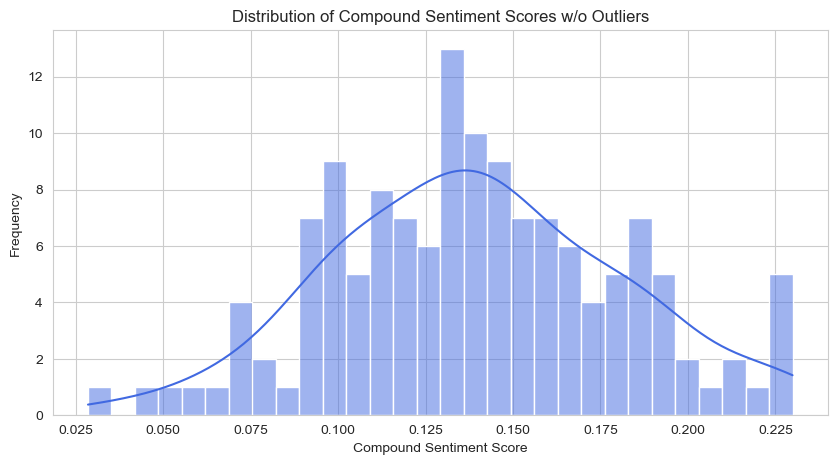

In [19]:
# Plot style
sns.set_style("whitegrid")

# Histogram with KDE
plt.figure(figsize=(10, 5))
sns.histplot(stock_sent["compound"], bins=30, kde=True, color="royalblue")

# Labels and title
plt.xlabel("Compound Sentiment Score")
plt.ylabel("Frequency")
plt.title("Distribution of Compound Sentiment Scores w/o Outliers")

# Show the plot
plt.show()

In [21]:
stock_sent.head()

,date,open,close,polarity,subjectivity,neg,neu,pos,compound,change,direction
0,2022-04-11,326.800,325.310,0.080180,0.276989,0.026003,0.882427,0.091573,0.208212,-1.490,down
1,2022-04-12,332.547,328.983,0.105863,0.298063,0.030610,0.881667,0.087727,0.187490,-3.564,down
2,2022-04-13,327.025,340.790,0.097394,0.313199,0.033751,0.885848,0.080401,0.143989,13.765,up
3,2022-04-14,333.097,328.333,0.070293,0.290837,0.059377,0.864065,0.076561,0.094256,-4.764,down
4,2022-04-18,329.677,334.763,0.117096,0.280977,0.024602,0.870471,0.104924,0.223253,5.086,up


In [23]:
stock_sent.describe()

,open,close,polarity,subjectivity,neg,neu,pos,compound,change
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,263.172133,262.081027,0.091915,0.277674,0.033865,0.887773,0.078348,0.139343,-1.091106
std,39.531854,38.986425,0.025585,0.025961,0.007885,0.013107,0.010603,0.041328,9.399596
min,186.000000,177.590000,0.038226,0.206218,0.019388,0.842723,0.058717,0.028505,-39.670000
25%,227.625000,227.995000,0.073569,0.262044,0.028717,0.878715,0.070349,0.110479,-7.077750
50%,264.405000,260.615000,0.090302,0.279359,0.032806,0.888673,0.077381,0.136878,-0.618300
75%,296.928500,295.641750,0.106174,0.293683,0.038118,0.897293,0.085011,0.165334,5.064500
max,358.243000,342.717000,0.207754,0.343988,0.063797,0.918091,0.108199,0.229899,16.600000


## Granger Causality Test

To determine whether past sentiment values have a predictive relationship with stock movement, we conducted a Granger Causality Test on different lag values. This statistical test helps **evaluate if past values of compound can help forecast direction.**

In [27]:
# data variable to input into granger
data = stock_sent[["change", "compound"]].pct_change().dropna()

In [29]:
gc_test = sm.tsa.stattools.grangercausalitytests(data, maxlag=8)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5271  , p=0.4691  , df_denom=133, df_num=1
ssr based chi2 test:   chi2=0.5390  , p=0.4628  , df=1
likelihood ratio test: chi2=0.5380  , p=0.4633  , df=1
parameter F test:         F=0.5271  , p=0.4691  , df_denom=133, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2944  , p=0.7455  , df_denom=130, df_num=2
ssr based chi2 test:   chi2=0.6114  , p=0.7366  , df=2
likelihood ratio test: chi2=0.6100  , p=0.7371  , df=2
parameter F test:         F=0.2944  , p=0.7455  , df_denom=130, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3823  , p=0.7659  , df_denom=127, df_num=3
ssr based chi2 test:   chi2=1.2102  , p=0.7506  , df=3
likelihood ratio test: chi2=1.2047  , p=0.7519  , df=3
parameter F test:         F=0.3823  , p=0.7659  , df_denom=127, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2915  , p=0.8830  

Since p-values are below 0.05, this indicates a statistically significant predictive relationship between compound and direction over multiple lag periods. The lowest p-value were found from lag = 5, **suggesting that past sentiment scores at these lags have the strongest predictive power.**

### Creating Shifted Direction Columns

Based on the Granger results, we created delayed versions of the direction column, shifting past values forward to be used as predictive features:

In [34]:
stock_sent = stock_sent.copy()

stock_sent['d5'] = stock_sent['direction'].shift(5)
stock_sent['d6'] = stock_sent['direction'].shift(6)
stock_sent['d7'] = stock_sent['direction'].shift(7)
stock_sent['d8'] = stock_sent['direction'].shift(8)


In [36]:
stock_sent = stock_sent.dropna(subset=['d5', 'd6', 'd7', 'd8']).reset_index(drop=True)

In [38]:
stock_sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          130 non-null    object 
 1   open          130 non-null    float64
 2   close         130 non-null    float64
 3   polarity      130 non-null    float64
 4   subjectivity  130 non-null    float64
 5   neg           130 non-null    float64
 6   neu           130 non-null    float64
 7   pos           130 non-null    float64
 8   compound      130 non-null    float64
 9   change        130 non-null    float64
 10  direction     130 non-null    object 
 11  d5            130 non-null    object 
 12  d6            130 non-null    object 
 13  d7            130 non-null    object 
 14  d8            130 non-null    object 
dtypes: float64(9), object(6)
memory usage: 15.4+ KB


In [40]:
stock_sent.head()

,date,open,close,polarity,subjectivity,neg,neu,pos,compound,change,direction,d5,d6,d7,d8
0,2022-04-22,338.303,335.017,0.080144,0.286910,0.038263,0.874554,0.087191,0.121700,-3.286,down,down,up,down,down
1,2022-04-25,326.323,332.673,0.096963,0.293670,0.041374,0.870231,0.088399,0.164662,6.350,up,up,down,up,down
2,2022-04-26,331.810,292.140,0.070937,0.270831,0.032862,0.893372,0.073764,0.135932,-39.670,down,up,up,down,up
3,2022-04-29,300.750,290.253,0.066227,0.252710,0.043785,0.871938,0.084277,0.126083,-10.497,down,down,up,up,down
4,2022-05-02,286.923,300.980,0.101805,0.311844,0.037111,0.869831,0.093054,0.187936,14.057,up,down,down,up,up


## Training the Random Forest Model

With the selected features, we trained a Random Forest Classifier using:

In [44]:
#Here we test the model iterating y value ['d5','d6','d7','d8']

X = stock_sent[['compound']]
y= stock_sent[['d5']]

After testing different models, the best accuracy was achieved using X = compound sentiment scores and **y = d5 (direction shifted by 5 days)**, meaning that stock movement 5 days ahead was best predicted using current sentiment scores.

Before interpreting the model’s performance, it is essential to verify the class balance of the target variable (d5). If the dataset is heavily imbalanced, the accuracy metric alone may not fully reflect the model's effectiveness.

Class Distribution:
d5
down    66
up      64
Name: count, dtype: int64

Percentage Distribution:
d5
down    50.769231
up      49.230769
Name: proportion, dtype: float64


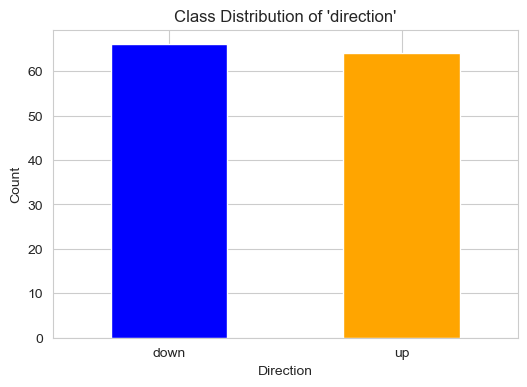

In [48]:
# Count the occurrences of each class
class_counts = stock_sent['d5'].value_counts()

# Calculate the percentage of each class
class_percentages = stock_sent['d5'].value_counts(normalize=True) * 100

# Display results
print("Class Distribution:")
print(class_counts)
print("\nPercentage Distribution:")
print(class_percentages)

# Optional: Visualizing the class balance
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title("Class Distribution of 'direction'")
plt.xlabel("Direction")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


Train Accuracy: 0.90
Test Accuracy: 0.69
Test Precision: 0.59
Test Recall: 0.81


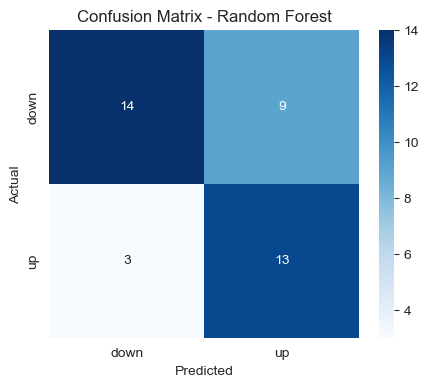

In [50]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Make sure 'y' is a 1-dimensional array
y_train = y_train.values.ravel()  # or y_train = y_train.squeeze()
y_test = y_test.values.ravel()    # or y_test = y_test.squeeze()

# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, pos_label='up')
test_recall = recall_score(y_test, y_pred_test, pos_label='up')

# Print results
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['down', 'up'], yticklabels=['down', 'up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


The Random Forest model achieved a **test accuracy of 69%**, indicating a reasonable ability to generalize beyond the training data. On the other hand, the **recall of 81% shows that the model effectively identifies most actual positive cases**, prioritizing sensitivity over precision.